In [1]:
from libraries import lib
from libraries.NeuralStates import *
import qutip as qt
import torch.nn as nn 
import torch
import numpy as np
import matplotlib.pyplot as plt
from kan import *

In [2]:
def set_gradients(sampled_vector: MHNeuralState, N, J, Gamma, model): # also only for log(amp), phase
    nn_output_calcs = {}
    def model_to_output(x):
        if x in sampled_vector.nn_output:
            return sampled_vector.nn_output[x]
        if x in nn_output_calcs:
            return nn_output_calcs[x]
        tens = torch.tensor([lib.generate_state_array(x, N)], dtype = torch.float32)
        output = model(tens)[0]
        nn_output_calcs[x] = output
        return output
    def output_to_log(x):
        return x[0] + 1.j * x[1]

    elocs = {}
    re_grad_logs = {}
    im_grad_logs = {}
    params = [p for p in model.parameters()]
    for basis_state in sampled_vector.distribution:
        eloc = 0
        nn_output = sampled_vector.nn_output[basis_state]
        for adjacency in lib.generate_adjacencies(basis_state, N):
            nn_output_prime = model_to_output(adjacency)
            eloc += lib.calc_H_elem(N, J, Gamma, basis_state, adjacency) * torch.exp(output_to_log(nn_output_prime) - output_to_log(nn_output))
        elocs[basis_state] = eloc.detach()
        
        nn_output[0].backward(retain_graph=True)
        real_grads = [p.grad.clone() for p in params]
        for p in params: p.grad = None
        nn_output[1].backward(retain_graph=True)
        imag_grads = [-p.grad.clone() for p in params]
        re_grad_logs[basis_state] = real_grads
        im_grad_logs[basis_state] = imag_grads

    E_eloc = (sum(sampled_vector.distribution[x] * elocs[x] for x in sampled_vector.distribution) / sampled_vector.samples).real

    for i in range(len(params)):
        E_grad_times_loc = sum((re_grad_logs[x][i] * elocs[x].real - im_grad_logs[x][i] * elocs[x].imag) * \
                               sampled_vector.distribution[x] for x in sampled_vector.distribution) / sampled_vector.samples
        E_grad = sum(re_grad_logs[x][i] * sampled_vector.distribution[x] for x in sampled_vector.distribution) / sampled_vector.samples
        params[i].grad = E_grad_times_loc - E_grad * E_eloc

    return E_eloc

def set_gradients_exact(sampled_vector: MHNeuralState, N, J, Gamma, model): # also only for log(amp), phase
    nn_output_calcs = {}
    def model_to_output(x):
        if x in sampled_vector.nn_output:
            return sampled_vector.nn_output[x]
        if x in nn_output_calcs:
            return nn_output_calcs[x]
        tens = torch.tensor([lib.generate_state_array(x, N)], dtype = torch.float32)
        output = model(tens)[0]
        nn_output_calcs[x] = output
        return output
    def output_to_log(x):
        return x[0] + 1.j * x[1]

    elocs = {}
    re_grad_logs = {}
    im_grad_logs = {}
    amp = 0
    params = [p for p in model.parameters()]
    for basis_state in sampled_vector.values:
        eloc = 0
        nn_output = sampled_vector.nn_output[basis_state]
        for adjacency in lib.generate_adjacencies(basis_state, N):
            nn_output_prime = model_to_output(adjacency)
            eloc += lib.calc_H_elem(N, J, Gamma, basis_state, adjacency) * torch.exp(output_to_log(nn_output_prime) - output_to_log(nn_output))
        elocs[basis_state] = eloc.detach()
        
        nn_output[0].backward(retain_graph=True)
        real_grads = [p.grad.clone() for p in params]
        for p in params: p.grad = None
        nn_output[1].backward(retain_graph=True)
        imag_grads = [-p.grad.clone() for p in params]
        re_grad_logs[basis_state] = real_grads
        im_grad_logs[basis_state] = imag_grads

        amp += abs(sampled_vector.values[basis_state].detach()) ** 2

    E_eloc = (sum(abs(sampled_vector.values[x].detach())** 2 * elocs[x] for x in sampled_vector.values) / amp).real

    for i in range(len(params)):
        E_grad_times_loc = sum((re_grad_logs[x][i] * elocs[x].real - im_grad_logs[x][i] * elocs[x].imag) * \
                                abs(sampled_vector.values[x].detach()) ** 2 for x in sampled_vector.values) / amp
        E_grad = sum(re_grad_logs[x][i] * abs(sampled_vector.values[x].detach()) ** 2 for x in sampled_vector.values) / amp
        params[i].grad = E_grad_times_loc - E_grad * E_eloc

    return E_eloc

def generate_eloc_distr(sampled_vector, N, J, Gamma, model):
    nn_output_calcs = {}
    def model_to_output(x):
        if x in sampled_vector.nn_output:
            return sampled_vector.nn_output[x]
        if x in nn_output_calcs:
            return nn_output_calcs[x]
        tens = torch.tensor([lib.generate_state_array(x, N)], dtype = torch.float32)
        output = model(tens)[0]
        nn_output_calcs[x] = output
        return output
    
    eloc_values = {}
    for basis_state in sampled_vector.distribution:
        eloc = 0
        output = model_to_output(basis_state)
        for adjacency in lib.generate_adjacencies(basis_state, N):
            output_prime = model_to_output(adjacency)
            eloc += lib.calc_H_elem(N, J, Gamma, basis_state, adjacency) * torch.exp(output_prime[0] - output[0] + 1.j * 2 * np.pi * (output_prime[1] - output[1]))
        eloc_values[basis_state] = eloc
    return eloc_values

def generate_input_samples(N, samples):
    return torch.tensor([lib.generate_state_array(x, N) for x in samples]).to(torch.float32)

In [3]:
def log_amp_phase(nn_output):
    return torch.exp(nn_output[:, 0] + 1.j * nn_output[:, 1])
def bitflip_x(x, N, flips):
    new_x = x
    for _ in range(flips):
        new_x = x ^ (1 << npr.randint(0, N))
    return new_x

In [4]:
N, J, Gamma = 6, 1, 1
true_gse = lib.ground_state_energy(Gamma, N)
print(true_gse)

-7.727406610312546


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
input = lib.generate_input_torch(N)

cpu


In [7]:
kan_model = KAN(width=[N, N, 2], device=device)

checkpoint directory created: ./model
saving model version 0.0


In [8]:
num_epochs = 300
num_samples = 128
data_rate = 1

In [9]:
vars = (N, J, Gamma)
epochs = []
energy_data = []
optimizer = torch.optim.Adam(kan_model.parameters(), lr=0.01)
# optimizer = torch.optim.SGD(kan_model.parameters(), lr=0.01)
# optimizer = LBFGS(kan_model.parameters(), lr=1, history_size=10, line_search_fn="strong_wolfe", tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)
for epoch in range(num_epochs):
    # loss.backward doesn't modify kan parameter grads so set_gradients doesn't work
    mh_state = MHNeuralState(N, kan_model, log_amp_phase, lambda x : bitflip_x(x, N, 1), 2 ** (N - 1), num_samples)
    eloc_distr = generate_eloc_distr(mh_state, N, J, Gamma, kan_model)
    eloc_list = torch.tensor([eloc_distr[x] for x in mh_state.list])
    psi = kan_model(generate_input_samples(N, mh_state.list))
    log_amp = psi[:, 0]; phase = psi[:, 1]
    eloc_r = eloc_list.real
    eloc_i = eloc_list.imag
    energy = eloc_r.mean()
    loss = ((eloc_r - eloc_r.mean()).detach() * log_amp + (eloc_i - eloc_i.mean()).detach() * phase).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % data_rate == 0:
        energy_data.append(energy)
        epochs.append(epoch)
    print(epoch, energy)
    # loss_data.append(loss_fn(model(input), vars, amp_phase).item())

# find groud state
gs = lib.model_to_ground_state(kan_model, input, log_amp_phase)

c:\Users\taoha\anaconda3\envs\kans\Lib\site-packages\kan\MultKAN.py:813: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1808.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
c:\Users\taoha\anaconda3\envs\kans\Lib\site-packages\kan\MultKAN.py:823: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1808.)
  input_range = torch.std(preacts, dim=0) + 0.1
c:\Users\taoha\anaconda3\envs\kans\Lib\site-packages\kan\MultKAN.py:824: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (inpu

0 tensor(-5.2807)
1 tensor(-5.4081)
2 tensor(-5.1646)
3 tensor(-6.3754)
4 tensor(-6.0062)
5 tensor(-6.3664)
6 tensor(-5.6290)
7 tensor(-6.0465)
8 tensor(-6.0795)
9 tensor(-6.2117)
10 tensor(-5.2132)
11 tensor(-5.4989)
12 tensor(-5.5291)
13 tensor(-5.9638)
14 tensor(-6.6654)
15 tensor(-5.8282)
16 tensor(-6.4349)
17 tensor(-5.4979)
18 tensor(-6.1281)
19 tensor(-6.2208)
20 tensor(-6.4723)
21 tensor(-6.2554)
22 tensor(-6.7502)
23 tensor(-5.7751)
24 tensor(-5.8554)
25 tensor(-6.5683)
26 tensor(-7.1733)
27 tensor(-6.1212)
28 tensor(-5.7045)
29 tensor(-6.1925)
30 tensor(-6.3275)
31 tensor(-6.1326)
32 tensor(-6.5739)
33 tensor(-6.2963)
34 tensor(-6.6712)
35 tensor(-7.0562)
36 tensor(-6.1193)
37 tensor(-6.7186)
38 tensor(-6.8111)
39 tensor(-6.5906)
40 tensor(-6.7198)
41 tensor(-7.1619)
42 tensor(-7.0712)
43 tensor(-6.9770)
44 tensor(-7.0262)
45 tensor(-7.2920)
46 tensor(-6.8417)
47 tensor(-7.2818)
48 tensor(-7.2740)
49 tensor(-7.7840)
50 tensor(-7.3499)
51 tensor(-7.3973)
52 tensor(-7.4259)
53 

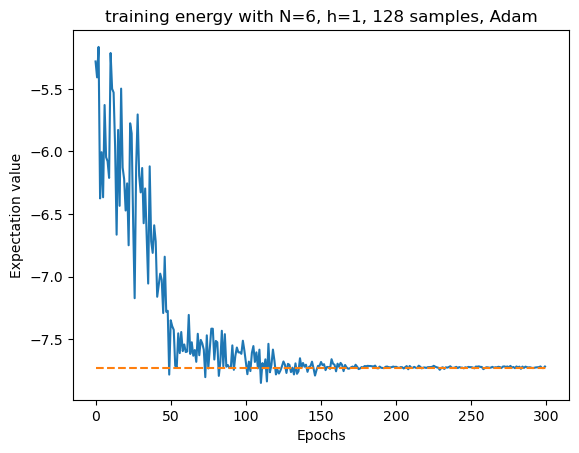

In [10]:
plt.plot(epochs, energy_data)
plt.plot([0, num_epochs], [lib.ground_state_energy(Gamma, N)] * 2, linestyle = '--')
plt.title(f'training energy with N={N}, h={Gamma}, {num_samples} samples, Adam')
plt.xlabel('Epochs')
plt.ylabel('Expectation value')
plt.show()

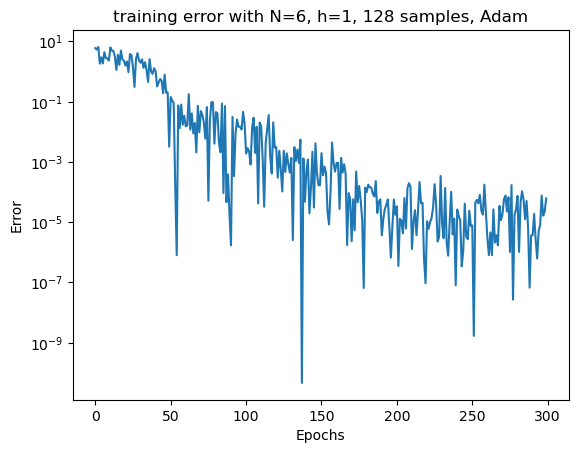

In [11]:
err = (np.array(energy_data) - true_gse) ** 2
plt.plot(epochs, err)
plt.title(f'training error with N={N}, h={Gamma}, {num_samples} samples, Adam')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.yscale('log')
plt.show()

In [12]:
qt.fidelity(gs, lib.TFIM_hamiltonian(N, J, Gamma).eigenstates()[1][0])

np.float64(0.9999800087681285)

In [13]:
np.array(energy_data[200:]).std()

np.float32(0.0058922423)

In [14]:
Gamma = 0.1
vars = (N, J, Gamma)
epochs = []
energy_data = []
optimizer = torch.optim.Adam(kan_model.parameters(), lr=0.01)
for epoch in range(num_epochs):
    # loss.backward doesn't modify kan parameter grads so set_gradients doesn't work
    mh_state = MHNeuralState(N, kan_model, log_amp_phase, lambda x : bitflip_x(x, N, 1), 2 ** (N - 1), num_samples)
    eloc_distr = generate_eloc_distr(mh_state, N, J, Gamma, kan_model)
    eloc_list = torch.tensor([eloc_distr[x] for x in mh_state.list])
    psi = kan_model(generate_input_samples(N, mh_state.list))
    log_amp = psi[:, 0]; phase = psi[:, 1]
    eloc_r = eloc_list.real
    eloc_i = eloc_list.imag
    energy = eloc_r.mean()
    loss = ((eloc_r - eloc_r.mean()).detach() * log_amp + (eloc_i - eloc_i.mean()).detach() * phase).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % data_rate == 0:
        energy_data.append(energy)
        epochs.append(epoch)
    print(epoch, energy)

# find groud state
gs = lib.model_to_ground_state(kan_model, input, log_amp_phase)

c:\Users\taoha\anaconda3\envs\kans\Lib\site-packages\kan\MultKAN.py:813: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1808.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
c:\Users\taoha\anaconda3\envs\kans\Lib\site-packages\kan\MultKAN.py:823: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1808.)
  input_range = torch.std(preacts, dim=0) + 0.1
c:\Users\taoha\anaconda3\envs\kans\Lib\site-packages\kan\MultKAN.py:824: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (inpu

0 tensor(-3.9796)
1 tensor(-4.7313)
2 tensor(-5.1186)
3 tensor(-5.3961)
4 tensor(-4.0644)
5 tensor(-4.6216)
6 tensor(-5.2225)
7 tensor(-5.4544)
8 tensor(-4.8423)
9 tensor(-5.1522)
10 tensor(-5.8142)
11 tensor(-5.3720)
12 tensor(-5.3293)
13 tensor(-5.7672)
14 tensor(-5.9754)
15 tensor(-5.7235)
16 tensor(-5.0557)
17 tensor(-4.7795)
18 tensor(-5.7562)
19 tensor(-6.0147)
20 tensor(-5.8815)
21 tensor(-5.6317)
22 tensor(-6.0082)
23 tensor(-5.9620)
24 tensor(-5.7307)
25 tensor(-5.4970)
26 tensor(-5.4437)
27 tensor(-6.0186)
28 tensor(-5.6926)
29 tensor(-5.7227)
30 tensor(-5.6537)
31 tensor(-6.0199)
32 tensor(-6.0194)
33 tensor(-5.4653)
34 tensor(-5.9058)
35 tensor(-6.0085)
36 tensor(-5.1030)
37 tensor(-6.0186)
38 tensor(-5.3512)
39 tensor(-5.8598)
40 tensor(-6.0251)
41 tensor(-5.9928)
42 tensor(-6.0108)
43 tensor(-5.8377)
44 tensor(-6.0051)
45 tensor(-6.0175)
46 tensor(-6.0133)
47 tensor(-5.9043)
48 tensor(-6.0204)
49 tensor(-6.0200)
50 tensor(-6.0196)
51 tensor(-6.0267)
52 tensor(-6.0275)
53 

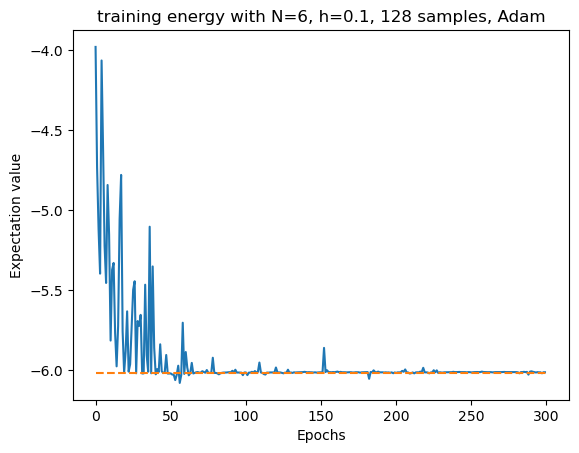

In [15]:
plt.plot(epochs, energy_data)
plt.plot([0, num_epochs], [lib.ground_state_energy(Gamma, N)] * 2, linestyle = '--')
plt.title(f'training energy with N={N}, h={Gamma}, {num_samples} samples, Adam')
plt.xlabel('Epochs')
plt.ylabel('Expectation value')
plt.show()

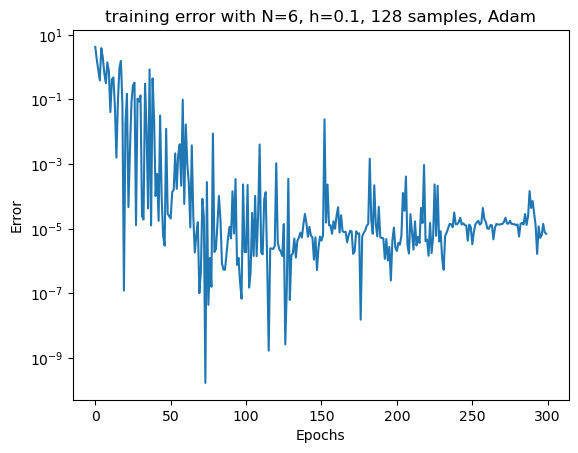

In [17]:
err = (np.array(energy_data) - lib.ground_state_energy(Gamma, N)) ** 2
plt.plot(epochs, err)
plt.title(f'training error with N={N}, h={Gamma}, {num_samples} samples, Adam')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.yscale('log')
plt.show()

In [18]:
qt.fidelity(gs, lib.TFIM_hamiltonian(N, J, Gamma).eigenstates()[1][0])

np.float64(0.894566394311012)

In [19]:
np.array(energy_data[200:]).std()

np.float32(0.0046055466)

In [20]:
Gamma = 10
vars = (N, J, Gamma)
epochs = []
energy_data = []
optimizer = torch.optim.Adam(kan_model.parameters(), lr=0.01)
for epoch in range(num_epochs):
    # loss.backward doesn't modify kan parameter grads so set_gradients doesn't work
    mh_state = MHNeuralState(N, kan_model, log_amp_phase, lambda x : bitflip_x(x, N, 1), 2 ** (N - 1), num_samples)
    eloc_distr = generate_eloc_distr(mh_state, N, J, Gamma, kan_model)
    eloc_list = torch.tensor([eloc_distr[x] for x in mh_state.list])
    psi = kan_model(generate_input_samples(N, mh_state.list))
    log_amp = psi[:, 0]; phase = psi[:, 1]
    eloc_r = eloc_list.real
    eloc_i = eloc_list.imag
    energy = eloc_r.mean()
    loss = ((eloc_r - eloc_r.mean()).detach() * log_amp + (eloc_i - eloc_i.mean()).detach() * phase).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % data_rate == 0:
        energy_data.append(energy)
        epochs.append(epoch)
    print(epoch, energy)

# find groud state
gs = lib.model_to_ground_state(kan_model, input, log_amp_phase)

c:\Users\taoha\anaconda3\envs\kans\Lib\site-packages\kan\MultKAN.py:813: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1808.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
c:\Users\taoha\anaconda3\envs\kans\Lib\site-packages\kan\MultKAN.py:823: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1808.)
  input_range = torch.std(preacts, dim=0) + 0.1
c:\Users\taoha\anaconda3\envs\kans\Lib\site-packages\kan\MultKAN.py:824: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (inpu

0 tensor(-13.3363)
1 tensor(-9.4036)
2 tensor(-28.4172)
3 tensor(-22.6507)
4 tensor(-14.4254)
5 tensor(-12.2206)
6 tensor(-14.8205)
7 tensor(-23.2475)
8 tensor(-20.1644)
9 tensor(-21.1632)
10 tensor(-22.8901)
11 tensor(-18.6012)
12 tensor(-24.5593)
13 tensor(-20.4768)
14 tensor(-24.8548)
15 tensor(-35.0276)
16 tensor(-30.5864)
17 tensor(-28.6451)
18 tensor(-30.3864)
19 tensor(-29.5260)
20 tensor(-31.4881)
21 tensor(-32.1529)
22 tensor(-31.6995)
23 tensor(-46.4498)
24 tensor(-35.6169)
25 tensor(-34.1307)
26 tensor(-34.8353)
27 tensor(-39.2522)
28 tensor(-35.2123)
29 tensor(-37.4340)
30 tensor(-36.7018)
31 tensor(-35.7166)
32 tensor(-39.3496)
33 tensor(-42.0058)
34 tensor(-42.0440)
35 tensor(-42.5156)
36 tensor(-36.3174)
37 tensor(-43.9949)
38 tensor(-36.4480)
39 tensor(-36.3063)
40 tensor(-42.2520)
41 tensor(-48.8201)
42 tensor(-34.7271)
43 tensor(-41.7060)
44 tensor(-47.0530)
45 tensor(-38.4766)
46 tensor(-44.5432)
47 tensor(-36.7416)
48 tensor(-38.6323)
49 tensor(-38.3436)
50 tensor(-

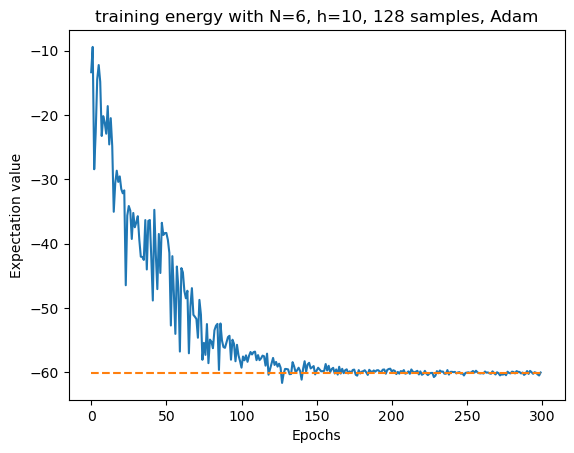

In [21]:
plt.plot(epochs, energy_data)
plt.plot([0, num_epochs], [lib.ground_state_energy(Gamma, N)] * 2, linestyle = '--')
plt.title(f'training energy with N={N}, h={Gamma}, {num_samples} samples, Adam')
plt.xlabel('Epochs')
plt.ylabel('Expectation value')
plt.show()

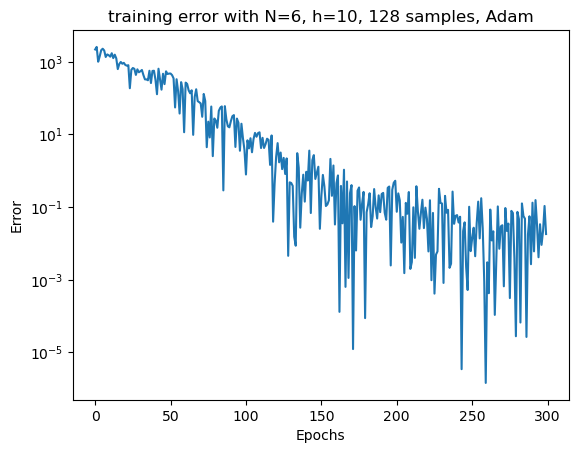

In [22]:
err = (np.array(energy_data) - lib.ground_state_energy(Gamma, N)) ** 2
plt.plot(epochs, err)
plt.title(f'training error with N={N}, h={Gamma}, {num_samples} samples, Adam')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.yscale('log')
plt.show()

In [23]:
qt.fidelity(gs, lib.TFIM_hamiltonian(N, J, Gamma).eigenstates()[1][0])

np.float64(0.9993345808555567)

In [24]:
np.array(energy_data[200:]).std()

np.float32(0.21980014)